### **유저 세그멘테이션(User Segmentation) 및 프로파일링(profiling) 분석**

데이터베이스 분석에서 유저 세그멘테이션과 프로파일링은 사용자를 더 깊이 이해하고, 이를 바탕으로 맞춤화된 전략을 수립하는 데 필수적인 기법입니다.


**유저 세그멘테이션 (User Segmentation)**

유저 세그멘테이션은 공통된 특성을 가진 사용자들을 그룹화하여 분석하는 방식입니다. 이를 통해 전체 사용자를 더 작은 단위로 나누어 각 그룹의 특징을 발견하고 마케팅에 활용할 수 있습니다.

**유저 프로파일링 (User Profiling)**

유저 프로파일링은 사용자의 행동, 선호도, 특성 등을 기반으로 상세하고 데이터 중심적인 설명 또는 프로필을 생성하는 과정입니다. 이를 통해 사용자의 니즈, 관심사, 동기 등을 깊이 이해할 수 있습니다.


---

1. 거래 행동 기반 사용자 군집화(KMeans 등)
2. 각 세그먼트별 거래 특성 및 리스크 프로파일 정의
3. 정상 사용자 vs 고위험 사용자 행동 차이 비교

=== 클러스터별 주요 특징 평균값 ===
         txn_count  total_amount   avg_amount  std_amount  type_count  \
cluster                                                                 
0             1.15     201909.40    178026.58      638.55         1.0   
1             1.00    4953893.08   4953893.08        0.00         1.0   
2             3.20   39262238.71  16779815.11   663344.84         1.0   
3             2.00     113840.43     56920.22     2159.44         2.0   

         fraud_ratio  flagged_ratio  count  ratio(%)  
cluster                                               
0                0.0            0.0  99982     99.98  
1                1.0            1.0      1      0.00  
2                0.0            0.0     15      0.02  
3                0.0            0.0      1      0.00  


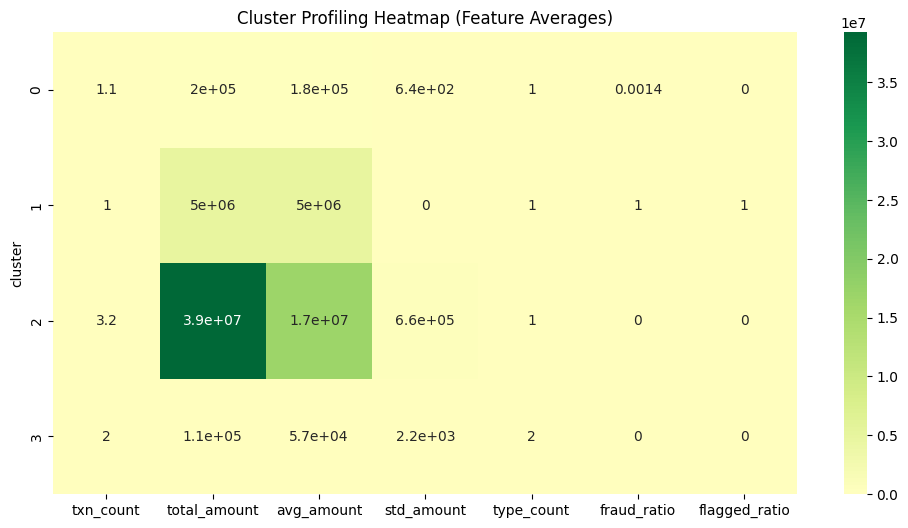

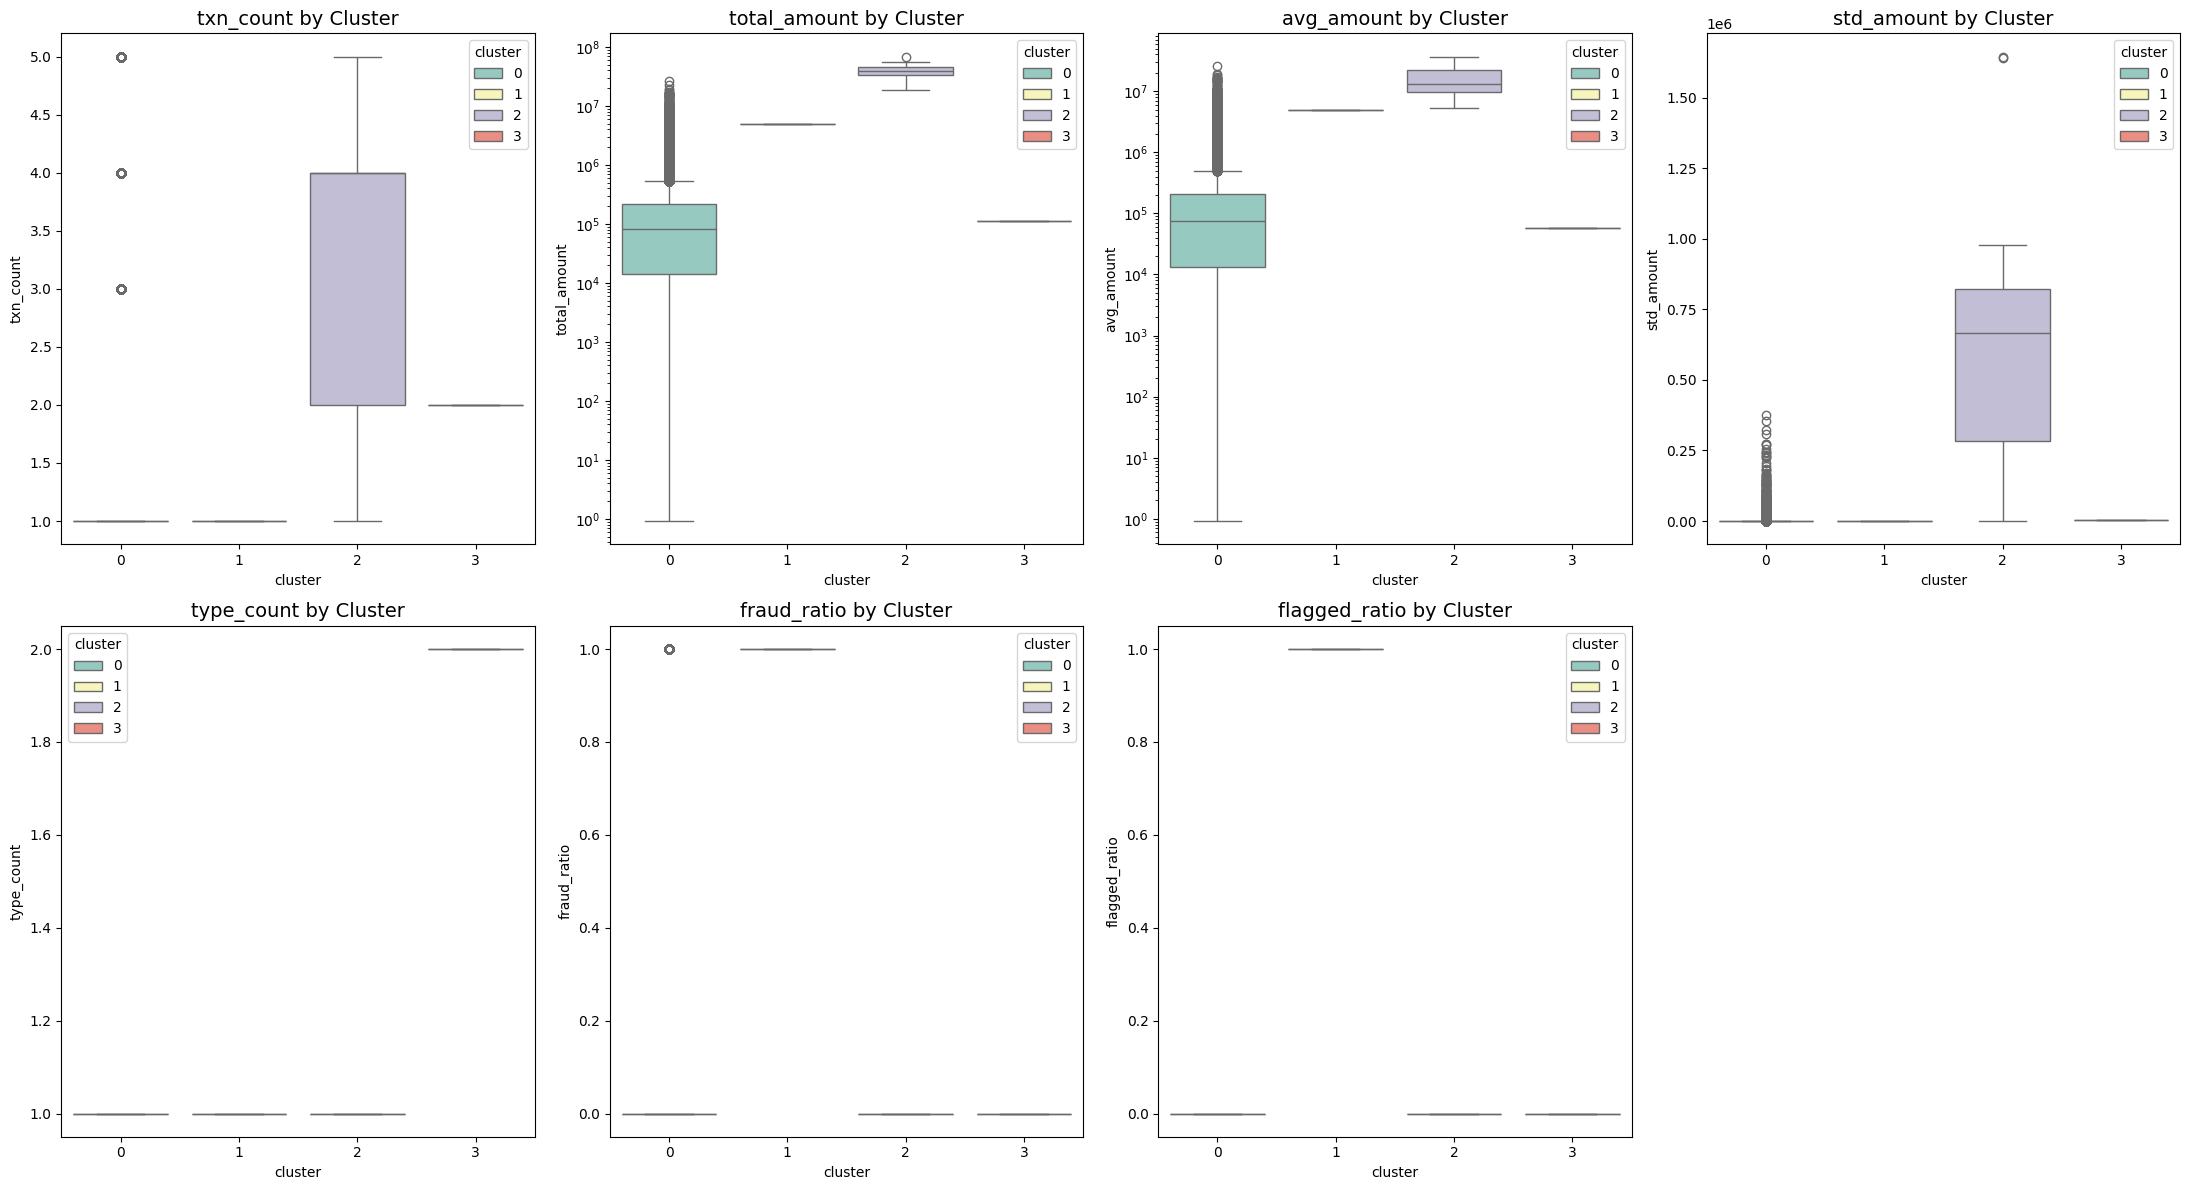

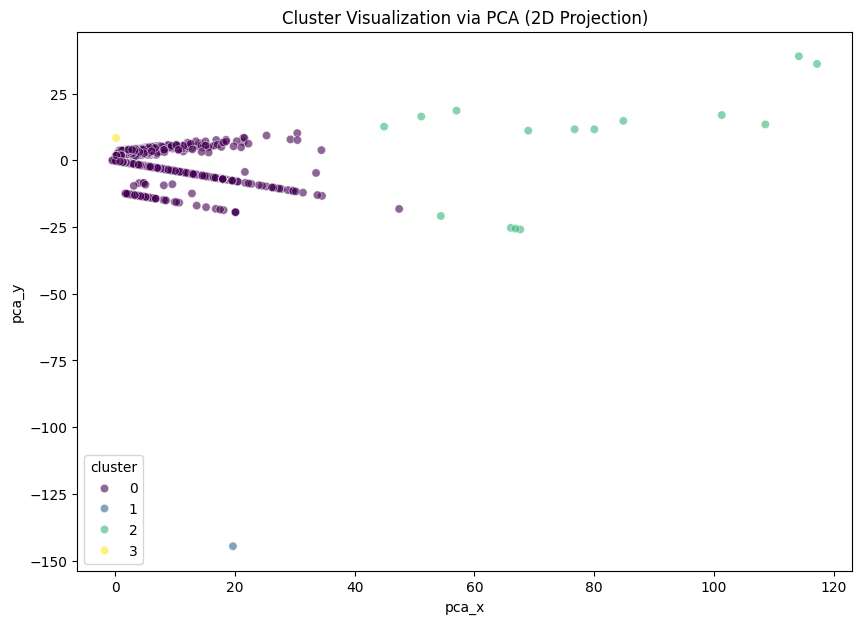

In [16]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# MySQL 연결
#conn = mysql.connector.connect(
#   host="localhost",
#    user="root",
#   password="Lee030414*",
#     database="paysim")
#pandas가 최신 버전으로 업데이트되면서 mysql-connector 객체를 직접 인계받는 대신, SQLAlchemy 엔진을 사용하는 것을 권장합니다.

# 1. SQLAlchemy 엔진 생성 (mysql-connector-python 기반)
# 형식: mysql+mysqlconnector://[user]:[password]@[host]/[database]
user = "root"
password = "Lee030414*"
host = "localhost"
database = "paysim"

engine = create_engine(f"mysql+mysqlconnector://{user}:{password}@{host}/{database}")

# 2️ 거래 데이터 로드 (송신자→수신자 네트워크)
query = """
SELECT *
FROM user_features;
"""

df = pd.read_sql(query, engine)
feature_cols = [
    'txn_count',
    'total_amount',
    'avg_amount',
    'std_amount',
    'type_count',
    'fraud_ratio',
    'flagged_ratio'
]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[feature_cols]) 

kmeans = KMeans(n_clusters=4, random_state=42) 
df['cluster'] = kmeans.fit_predict(X_scaled)

#  1. 클러스터별 주요 feature 평균 계산
cluster_profile = df.groupby('cluster')[feature_cols].mean().round(2)
cluster_profile['count'] = df['cluster'].value_counts().sort_index().values
cluster_profile['ratio(%)'] = (df['cluster'].value_counts(normalize=True)
                               .sort_index().values * 100).round(2)
print("=== 클러스터별 주요 특징 평균값 ===")
print(cluster_profile)

#  2. 히트맵 시각화 (Z-score 기준으로 변경하여 대비 명확화)
plt.figure(figsize=(12, 6))
# 평균값이 아닌 스케일링된 값의 평균을 사용하여 특징을 더 명확하게 시각화
sns.heatmap(df.groupby('cluster')[feature_cols].mean(), annot=True, cmap='RdYlGn', center=df[feature_cols].mean().mean())
plt.title("Cluster Profiling Heatmap (Feature Averages)")
plt.show()

# 3.Boxplot 자동 배열 (한 줄에 4개씩, 2행으로 구성)
# feature_cols가 7개이므로 2x4 배열로 그립니다.
fig, axes = plt.subplots(2, 4, figsize=(22, 12))
axes = axes.flatten() # 2D 배열을 1D로 평탄화하여 반복문 사용 용이하게 함

for i, col in enumerate(feature_cols):
    sns.boxplot(x='cluster', y=col, data=df, ax=axes[i], hue='cluster', palette='Set3')
    axes[i].set_title(f"{col} by Cluster", fontsize=14)
    # 금액 데이터는 로그 스케일 권장 (편차가 클 경우)
    if col in ['total_amount', 'avg_amount']:
        axes[i].set_yscale('log')

# 남는 빈 그래프(8번째)는 삭제
if len(feature_cols) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

# 4. 간단한 자동 해석 함수
def interpret_cluster(row):
    desc = []
    if row['txn_count'] > cluster_profile['txn_count'].mean():
        desc.append("거래빈도가 높은 편")
    else:
        desc.append("거래빈도가 낮은 편")
        
    if row['total_amount'] > cluster_profile['total_amount'].mean():
        desc.append("거래금액이 큰 편")
    else:
        desc.append("거래금액이 작은 편")
        
    if row['fraud_ratio'] > cluster_profile['fraud_ratio'].mean():
        desc.append("사기 시도 비율이 높음")
        
    if row['type_count'] > cluster_profile['type_count'].mean():
        desc.append("거래 유형이 다양함")
        
    if row['flagged_ratio'] > cluster_profile['flagged_ratio'].mean():
        desc.append("flagged 거래 비율이 높음")
    
    return ", ".join(desc)


from sklearn.decomposition import PCA

# 5. PCA 시각화 고도화
pca = PCA(n_components=2)
coords = pca.fit_transform(X_scaled)
df['pca_x'] = coords[:, 0]
df['pca_y'] = coords[:, 1]

plt.figure(figsize=(10, 7))
sns.scatterplot(x='pca_x', y='pca_y', hue='cluster', data=df, palette='viridis', alpha=0.6)
plt.title("Cluster Visualization via PCA (2D Projection)")
plt.show()

    - 결과
- 히트맵 해석

| 클러스터 | 주요 특징 | 해석 요약 |
| --- | --- | --- |
| **0번** | txn_count, total_amount, avg_amount 모두 낮음 | 거래빈도도 낮고 금액도 작음 → **비활성 일반 사용자군 (Inactive Users)** |
| **1번** | txn_count, total_amount, avg_amount 중간 수준, fraud_ratio 약간 높음 | 거래 규모는 중간이지만 사기 비율이 조금 있는 **위험 중간군 (Moderate-Risk Users)** |
| **2번** | txn_count·total_amount가 매우 높음 (파란색), fraud_ratio 낮음 | 거래 빈도·금액이 모두 큰 **활발한 정상 고액 사용자군 (High-Value Users)** |
| **3번** | txn_count, type_count가 약간 높지만 나머지 낮음  | 거래횟수 많고 유형 다양하지만 금액은 작음 → **다양한 소액 다거래형 사용자군 (Diversified Small-Volume Users)** |
|  |  |  |

- PCA 해석

| 클러스터 | 시각적 특징 | 가능 해석 |
| --- | --- | --- |
| 0 (보라) | 왼쪽에 밀집 / 값이 작고 유사한 고객들 | 일반적인 소액/저빈도 사용자 (대부분) |
| 1 (초록) | 오른쪽으로 길게 분포 / 거래 규모가 큰 고객들 | 거래 활발한 핵심 사용자 / VIP |
| 2 (노랑) | 소수의 특별한 위치 / 아웃라이어 가능성 | 특정 패턴 가진 사용자 (특정 Type만 사용 등) |
| 3 (파랑) | 아주 아래쪽에 혼자 존재 / 강력한 아웃라이어 | 극단적 이상치 (사기 or 특수 case) |

- 종합

> 0번(보라) - "거대한 섬": 히트맵에서 모든 수치가 낮게 나온 것처럼, 대부분의 사용자가 비슷한(평범한) 행동을 하기에 한곳에 뭉쳐 있는 것입니다.
>
> 1번(초록) - "길게 뻗은 줄기": 히트맵에서 규모가 중간 이상이라고 하셨죠? 거래 금액이나 빈도가 커질수록 0번 뭉치에서 오른쪽으로 길게 뻗어 나가는 양상을 보입니다.
>
> 2, 3번(노랑, 파랑) - "외딴섬": 히트맵에서 '매우 높음' 혹은 '특이함'으로 나타난 그룹입니다. 이들은 일반적인 사용자 패턴에서 완전히 벗어난 강력한 이상치(Outlier)입니다.
>
>특히 3번이 혼자 아래에 있다면, 다른 변수들은 낮지만 특정 변수(예: 사기 비율이나 특정 거래 유형) 하나가 압도적으로 튀기 때문에 발생하는 현상

    - 인사이트
- 사기 탐지 전략: 히트맵에서 사기 비율이 높았던 1번(초록) 중에서도 PCA 상에서 0번 뭉치와 멀리 떨어져 있는(오른쪽 끝) 사용자들을 우선 차단 대상으로 설정해야 합니다.

- 아웃라이어 처리: PCA에서 혼자 떨어져 있는 3번(파랑)은 모델 학습 시 방해가 될 수 있는 '노이즈'이거나, 혹은 **'가장 정교하게 설계된 신종 사기 패턴'**일 가능성이 높으므로 별도 전수 조사가 필요합니다.

- 마케팅/운영: 2번(노랑)처럼 거래 규모가 압도적인 그룹은 시스템 부하를 일으킬 수 있는 헤비 유저이므로 별도의 리미트 정책을 적용해야 합니다.